In [1]:
from matplotlib import pyplot as plt
import sys
import numpy as np
sys.path.insert(1, "/global/u1/j/jpalmer/miniconda3/envs/fast_lz/lib/python3.7/site-packages/")
import iminuit  
import uproot
from scipy.stats import poisson
import scipy.stats as stat
import fit_functions_sdp as ff
#import radiusFromEventSelection as rad
import itertools
import csv
import json
import os
from ipywidgets import IntProgress
import time as time_d
import pandas as pd


In [2]:
#IF YOU ARE READING IN A CSV 
#create this csv file by running https://gitlab.com/luxzeplin/analysis/alpaca/modules/tpc-spe-dpe-eventselection
#data = pd.read_csv("SPEDPEforfitting_test.csv")
#RUN THIS EVERY TIME YOU NEED TO RERUN THE FIT
data = pd.read_csv("/global/cfs/cdirs/lz/users/jpalmer/SPE-DPE-JP/ALPACA/Kr83data.csv")
data2 = data.sort_values(by=['chID'])
data3 = data2.groupby('chID')['chPulseArea_phd'].apply(list)
print(data3)
data3 = np.asarray(data3)
finalarray = np.zeros(540)
d = [data3[x] for x in range(data3.shape[0])]

my_final_values=np.array([np.array(xi) for xi in d])


chID
0      [0.626455, 1.47434, 1.0271299999999999, 0.5728...
1      [1.1392200000000001, 0.969543, 0.9148790000000...
2      [1.85168, -0.023281200000000002, 0.776296, 1.1...
3      [1.89058, -0.00926216, 0.841081, 1.11804, 0.69...
4      [1.33982, 1.11566, 0.9141870000000001, 2.1985,...
                             ...                        
536    [1.74815, 0.397934, 0.783878, 1.12409, 0.97965...
537    [1.40044, 0.8528540000000001, 0.689009, 0.6071...
538    [0.679362, 1.50312, 0.7690020000000001, 0.6236...
539    [1.14147, 1.09548, 0.8570200000000001, 0.63456...
540    [0.748197, 0.816863, 0.28592, 1.54391000000000...
Name: chPulseArea_phd, Length: 494, dtype: object


In [3]:
f=open('PMTpositions-LZ-09Apr18.txt','r')
lines=np.loadtxt(f, comments="#", delimiter=" ", unpack=False)

PMT_x = lines[:,1]
PMT_y = lines[:,2]

PMT_ID = lines[:,0]

PMT_top_IDS = np.arange(0,253)
PMT_bottom_IDS = np.arange(300,541)


0


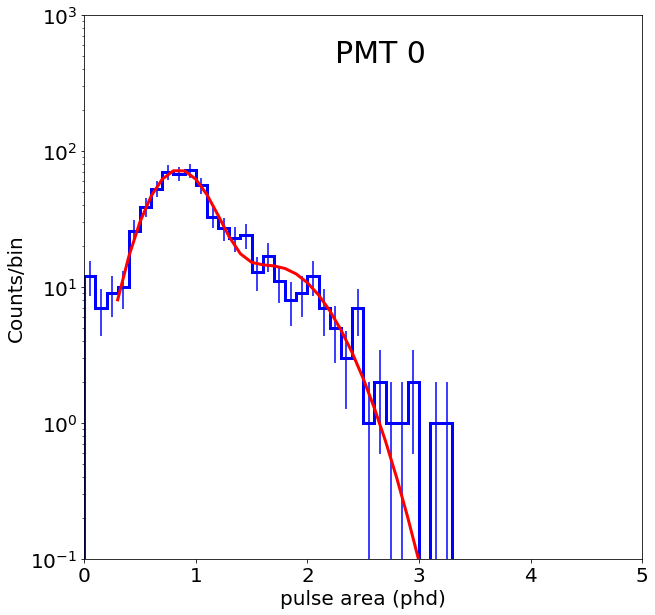

1


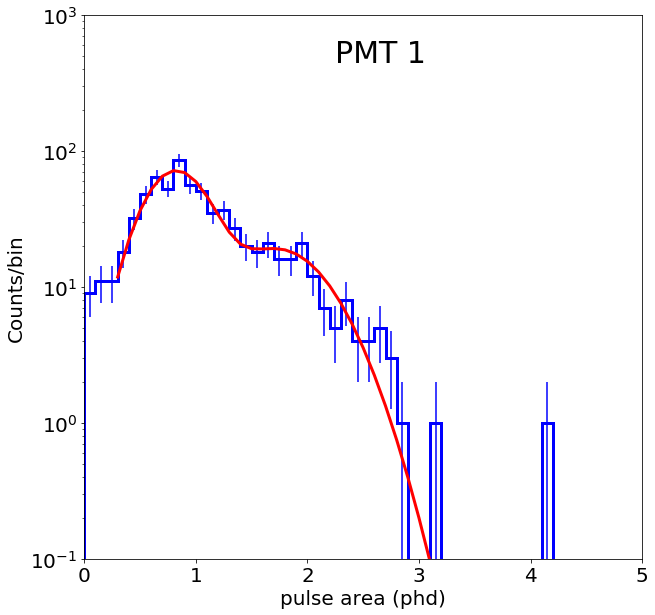

2


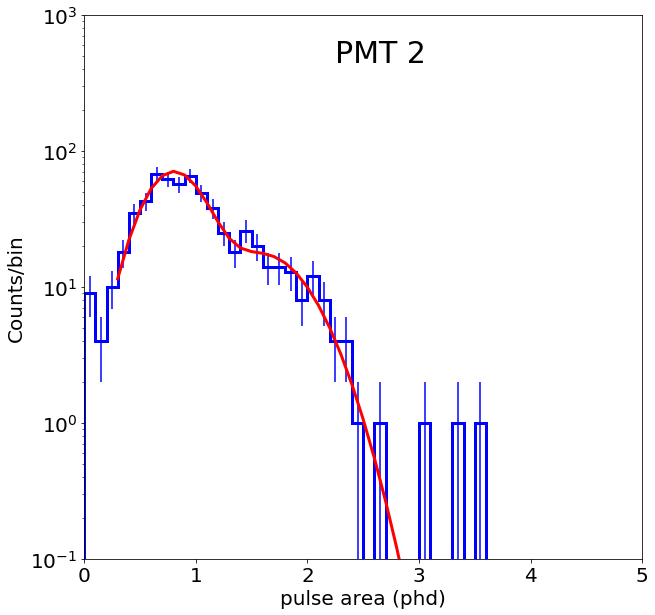

3


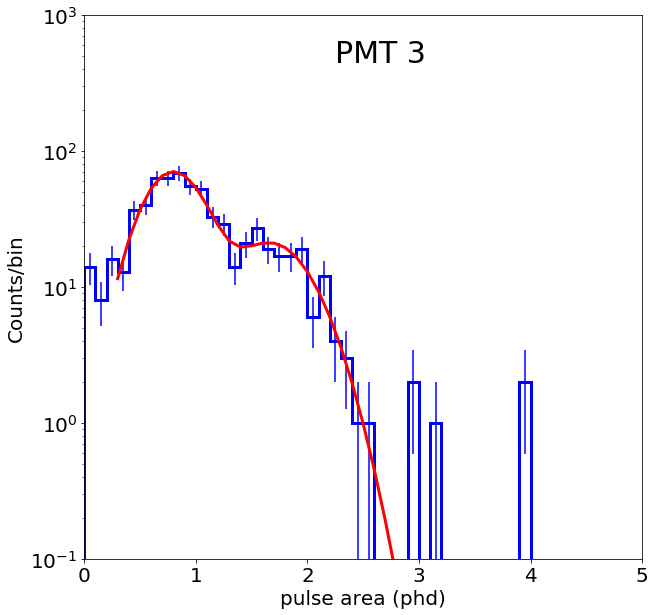

4


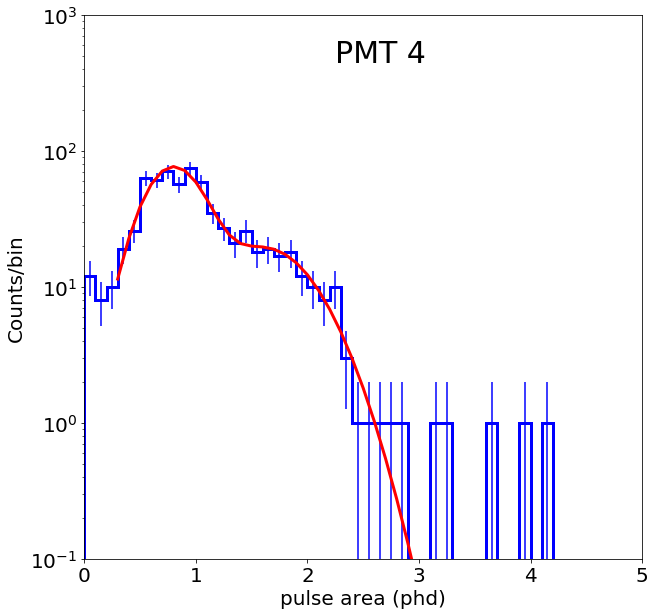

5


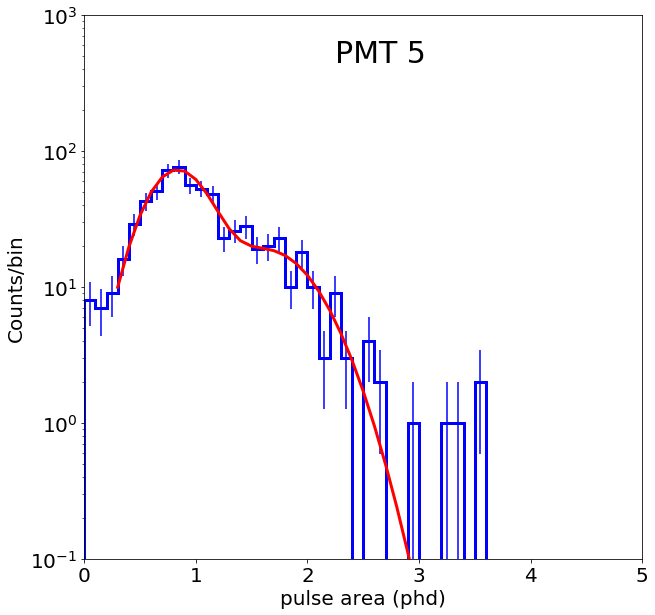

In [12]:
#%%capture
#Fitting for each PMT--------------------------------------------------------------------------------------------------------------------------------------------------------------------

file = open("PMT_params_sdp.txt", 'w')
file2 = open("PMT_params_errors_sdp.txt", 'w')
parameters = []
parameters_errors =[]

for i in itertools.chain(PMT_top_IDS,PMT_bottom_IDS):
    #Choosing particular PMT
    print(i)
    PMT_number=i #Choosing PMT number 

    if PMT_number < 300:
        PMT_data_full = np.asarray(my_final_values[PMT_number])
    elif PMT_number >=300:
        PMT_data_full = np.asarray(my_final_values[PMT_number-47])
    
    PMT_data = PMT_data_full[(PMT_data_full>0.2)&((PMT_data_full<2.8))]
    N_entries = PMT_data.shape[0]
    #Initial statistical parameters
    mu_init = np.mean(PMT_data[(PMT_data<1.5)])
    std_init = np.std(PMT_data[(PMT_data<1.5)])

    name_in = ["N_one","x1","s1","R","x2","s2"] #name of fit parameters
    params_in = [N_entries,mu_init,std_init,0.2,2.*mu_init,np.sqrt(2)*std_init] #initial parameters
    fix_in = [False,False,False,False,True,True] #fixing mean and sigma of second gaussian to help fit
    limit_in = [(N_entries*0.5,N_entries*1.5),(mu_init*0.8,mu_init*1.2),(std_init*0.8,std_init*1.2),
                (0.1,0.6),(None,None),(None,None)]


    #Defining our function to be minimized with initial parameters and limits
    minimizer = iminuit.Minuit.from_array_func(
                lambda p: ff.ULikelihood_r(PMT_data,p),
                params_in,
                name=name_in,
                fix=fix_in,
                limit=limit_in,
                errordef=0.5) #,pedantic=False)
    #Minimizing
    minimizer.migrad()

    fix_in = [False,False,False,False,False,False] 
    #fit parameters
    fit_params = [v for v in minimizer.values.values()]
    fit_limit = [(fit_params[0]*0.9,fit_params[0]*1.1),(fit_params[1]*0.95,fit_params[1]*1.05),(fit_params[2]*0.95,fit_params[2]*1.05),
                  (fit_params[3]*0.9,fit_params[3]*1.1),(fit_params[1]*2*0.9,fit_params[1]*2*1.1),(fit_params[2]*np.sqrt(2)*0.9,fit_params[2]*np.sqrt(2)*1.1)]

    #Minimizing for a second time with better initial parameters

    minimizer = iminuit.Minuit.from_array_func(
    lambda p: ff.ULikelihood_r(PMT_data,p),
    fit_params,
    name=name_in,
    fix=fix_in,
    limit=fit_limit,
    errordef=0.5)

    minimizer.migrad()
    
    
    fit_params = [v for v in minimizer.values.values()]
    fit_params_error = [v for v in minimizer.errors.values()]


    #Plotting
    plt.figure(figsize=(10,10))

    #plotting the data
    n, bins, patches = plt.hist(PMT_data_full,histtype='step',range=(0,5),bins=50,color='blue',linewidth=3)
    bin_centres = 0.5*(bins[1:]+bins[:-1])
    error = np.sqrt(n)
    plt.errorbar(bin_centres,n,yerr=error,color='blue',ls='None')

    #plotting the fit function
    y = ff.pdf_r(bins,fit_params)
    Norm = N_entries/y.sum()

    plt.plot(bins[bins>0.2],Norm*y[bins>0.2],color='Red',linewidth=3)

    plt.xlim(0,5)
    plt.yscale('log')
    plt.tick_params(axis='both', which='major', labelsize=20)
    plt.xlabel('pulse area (phd)',fontsize=20)
    plt.ylabel('Counts/bin',fontsize=20)
    plt.ylim(0.1,1000)
    
    plt.text(2.25,450,'PMT %s'%(PMT_number),fontsize=30)

    plt.show()
    plt.savefig('Fits_S1/%s.png' %(PMT_number))
    plt.close() 

    fit_params.append(PMT_number)

    parameters.append(fit_params)
    parameters_errors.append(fit_params_error)
    
    if i == 5:
        break

#json.dump(parameters,file)
#json.dump(parameters_errors,file2)
file.write(str(parameters))
file2.write(str(parameters_errors))
file.close()
file2.close()
